In [1]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from scipy.stats import norm
import plotly.graph_objects as go
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, StepLR, OneCycleLR
from pathlib import Path
import matplotlib.animation as animation
from sklearn.datasets import *
import segmentation_models_pytorch as smp

from rich import print
import imageio


from utils.Models import MLP
from utils.Datasets import BBdataset, MNISTdataset
from utils.utils import *
from utils.two_dim import data_distrib
from utils.sample import sample_mnist

seed = 233
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 0
print(f"Using device: {device}")


experiment_name = "gaussian2minst"  # 你可以根据需要动态设置这个变量
# log_dir = Path('experiments') / experiment_name / 'test' / time.strftime("%Y-%m-%d/%H_%M_%S/")
log_dir = Path('experiments') / experiment_name
log_dir.mkdir(parents=True, exist_ok=True)

/home/ljb/miniconda3/envs/sde/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: 0

In [2]:
def save_dataset(index, ret_ts, ret_bridge, ret_drift, ret_source, ret_target, metadata):
    (log_dir / 'data').mkdir(exist_ok=True)
    torch.save(ret_ts, log_dir / f'data/ts_{index}.pt')
    torch.save(ret_bridge, log_dir / f'data/bridge_{index}.pt')
    torch.save(ret_drift, log_dir / f'data/drift_{index}.pt')
    torch.save(ret_source, log_dir / f'data/source_{index}.pt')
    torch.save(ret_target, log_dir / f'data/target_{index}.pt')
    pickle.dump(metadata, open(log_dir / f'data/metadata_{index}.pkl', 'wb'))
    
    
def read_dataset(index):
    ret_ts = torch.load(log_dir / f'data/ts_{index}.pt')
    ret_bridge = torch.load(log_dir / f'data/bridge_{index}.pt')
    ret_drift = torch.load(log_dir / f'data/drift_{index}.pt')
    ret_source = torch.load(log_dir / f'data/source_{index}.pt')
    ret_target = torch.load(log_dir / f'data/target_{index}.pt')
    metadata = pickle.load(open(log_dir / f'data/metadata_{index}.pkl', 'rb'))
    return ret_ts, ret_bridge, ret_drift, ret_source, ret_target, metadata

In [2]:
def gen_mnist_array_in_order(range=(0, 1000)):
    """
    Generate MNIST array in order
    """
    train_ds = torchvision.datasets.MNIST(
        root="./data/", 
        train=True, 
        download=True
        )
    target = train_ds.data.view(-1, 1, 28, 28).float()
    
    # random choice nums samples
    target = target[range[0]:range[1]]
    source = torch.randn_like(target)
    return source, target

def gen_mnist_array(nums=25):
    """
    Generate MNIST array and random choice nums samples
    """
    train_ds = torchvision.datasets.MNIST(
        root="./data/", 
        train=True, 
        download=True
        )
    target = train_ds.data.view(-1, 1, 28, 28).float()
    
    # random choice nums samples
    target = target[torch.randperm(target.shape[0])[:nums]]

    source = torch.randn_like(target)
    return source, target

def gen_bridge(x, y, ts, T):
    """
    Generate bridge process from x to y
    """
    sigma=1
    bridge = torch.zeros((len(ts), *x.shape))
    drift = torch.zeros((len(ts), *x.shape))
    bridge[0] = x # Initial value
    for i in tqdm(range(len(ts) - 1)):
        dt = ts[i+1] - ts[i]      # dt = epsilon
        dydt = (y - bridge[i]) / (T - ts[i])
        drift[i, :] = dydt
        diffusion = sigma * torch.sqrt(dt) * torch.randn_like(x)
        bridge[i+1] = bridge[i] + dydt * dt
        bridge[i+1, :] += diffusion
    return bridge, drift

def gen_mnist_data_in_order(range=(0, 1000)):
    """
    Generate MNIST dataset in order
    """
    source, target = gen_mnist_array_in_order(range)
    epsilon = 0.001
    T = 1
    ts = torch.arange(0, T+epsilon, epsilon)
    
    # epsilon1 = 0.001
    # epsilon2 = 0.0001

    # t1 = torch.arange(0, 0.91, epsilon1)
    # t2 = torch.arange(0.91, T, epsilon2)
    # print(t1.shape, t2.shape)
    # ts = torch.concatenate((t1, t2))
    
    bridge, drift = gen_bridge(source, target, ts, T)
    return ts, bridge, drift, source, target

def gen_mnist_data(nums=100, change_epsilons=False):
    """
    Generate MNIST dataset
    """
    source, target = gen_mnist_array(nums)
    
    T = 1
    if change_epsilons:
        epsilon1 = 0.001
        epsilon2 = 0.0001

        t1 = torch.arange(0, 0.91, epsilon1)
        t2 = torch.arange(0.91, T, epsilon2)
        ts = torch.concatenate((t1, t2))
    else:
        epsilon = 0.001
        ts = torch.arange(0, T+epsilon, epsilon)
        
    
    bridge, drift = gen_bridge(source, target, ts, T)
    return ts, bridge, drift, source, target

ts, bridge, drift, source, target = gen_mnist_data(nums=25)
# ts, bridge, drift, source, target, ret = normalize_dataset(ts, bridge, drift, source, target)

100%|██████████| 1000/1000 [00:00<00:00, 3809.52it/s]


In [12]:
# for i in range(60):
#     ts, bridge, drift, source, target = gen_mnist_data_in_order((i*1000, (i+1)*1000))
#     ts, bridge, drift, source, target, metadata = normalize_dataset(ts, bridge, drift, source, target)
#     new_ds = MNISTdataset(ts, bridge, drift, source, target)
#     new_ds.metadata = metadata
#     pickle.dump(new_ds, open(log_dir / f'data/new_ds_{i}.pkl', 'wb'))

100%|██████████| 1000/1000 [00:06<00:00, 158.53it/s]


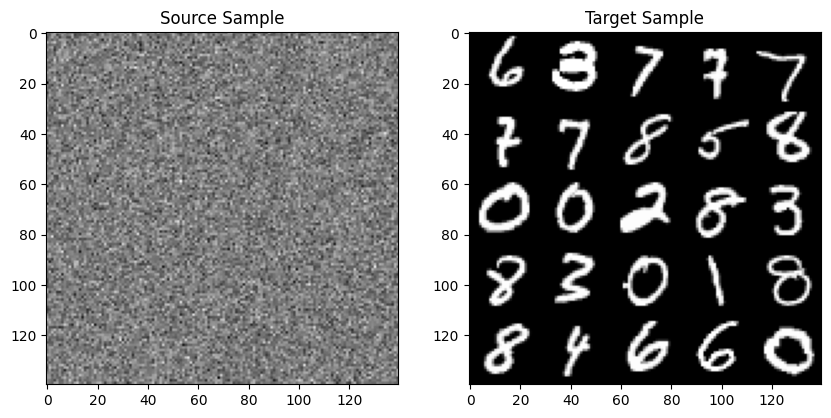

In [3]:
def concat_mnist(data):
    """
    Concatenates a batch of MNIST images into a single image.
    """
    data = data[:25]
    data = data.view(5, 5, 28, 28)
    data = torch.concatenate([torch.cat([data[i, j] for j in range(5)], dim=1) for i in range(5)], dim=0)
    return data

def plot_source_and_target_mnist(sour, targ, left_title="Source Sample", right_title="Target Sample", save_path=None, bound=8):
    """
    Plots a source and target sample from the MNIST dataset.
    """
    sour = concat_mnist(sour)
    targ = concat_mnist(targ)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(sour.cpu().numpy(), cmap='gray')
    axs[1].imshow(targ.cpu().numpy(), cmap='gray')
    axs[0].set_title(left_title)
    axs[1].set_title(right_title)
    fig.show()
    if save_path is not None:
        fig.savefig(save_path)

plot_source_and_target_mnist(source, target)

In [ ]:
"""
Not needed anymore for new dataset structure
"""

# ts, bridge, drift, source_sample, target = gen_mnist_data(nums=100)


# start = torch.cat(torch.split(source_sample.repeat(len(ts)-1, 1 ,1 ,1), 1, dim=1), dim=0)
# times = ts[:len(ts)-1].repeat(source_sample.shape[0]).reshape(-1, 1, 1, 1).repeat(1, 1, 28, 28)

# del source_sample, ts

# positions = torch.cat(torch.split(bridge[:-1].squeeze(), 1, dim=1), dim=0)

# del bridge

# scores = torch.cat(torch.split(drift[:-1].squeeze(), 1, dim=1), dim=0)

# del drift

# raw_data = torch.concat([start, times, positions, scores], dim=1)

# del start, times, positions, scores

# mean = torch.mean(raw_data, dim=0)
# std = torch.std(raw_data, dim=0)
# # raw_data = (raw_data - mean) / std
# print(torch.min(raw_data), torch.max(raw_data), raw_data.shape)
# print(f"Mean: {torch.mean(mean)}\nStd: {torch.mean(std)}")

In [3]:
# model = MLP(input_dim=3, output_dim=1, hidden_layers=4, hidden_dim=256).to(device)
# from utils.unet import UNet
# model = UNet(in_channels=3, out_channels=1, init_features=24).to(device)
# os.system("source ~/add_proxy.sh")
model = smp.Unet(
    encoder_name="efficientnet-b0",
    in_channels=3,
    encoder_depth=3, 
    decoder_channels=(64, 32, 16),
    classes=1,
    # decoder_attention_type="scse",
).to(device)
print(f"Model Parameters: {int(sum(p.numel() for p in model.parameters())/1e6)}M")

Model Parameters: 4M

In [10]:
def train(model, train_dl, optimizer, scheduler, loss_fn):
    losses = 0
    for training_data in train_dl:
        training_data = training_data[:,0].float().cpu()
        x, y = training_data[:, :-1], training_data[:, -1:]
        x = F.pad(x, (2, 2, 2, 2, 0, 0, 0, 0), 'constant', 0)
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        pred = pred[:, :, 2:-2, 2:-2]
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()
        losses += loss.item() / len(train_dl)
        
    return losses


  
for iter in range(60):
    epochs = 2
    batch_size = 8000
    lr = 1e-3

    new_ds = pickle.loads(open('experiments/gaussian2minst/data/new_ds_0.pkl', 'rb').read())
    new_dl = DataLoader(new_ds, batch_size=batch_size, shuffle=True, num_workers=10)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    # scheduler = OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(new_dl))
    scheduler = None

    loss_fn = nn.MSELoss()
    loss_list = []
    print('='*10+'model'+'='*10)
    print("batch_szie:{}, length:{}".format(*next(new_dl.__iter__()).shape)) # batch_szie, channel, length

    epoch_iterator = tqdm(range(epochs), desc="Training (lr: X)  (loss= X)", dynamic_ncols=True)
    model.train()
    for e in epoch_iterator:
        now_loss = train(model ,new_dl, optimizer, scheduler, loss_fn)
        loss_list.append(now_loss)
        cur_lr = optimizer.param_groups[-1]['lr']
        epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, now_loss))
        if e % 100 == 0:
            torch.save(model.state_dict(), log_dir / f'model_{int(e)}.pth')
    epoch_iterator.close()

==========model==========

batch_szie:8000, length:1

Training (lr: 0.00100)  (loss=0.74982):  50%|█████     | 1/2 [01:18<01:18, 78.08s/it]

In [7]:
    new_ds = pickle.loads(open('experiments/gaussian2minst/data/new_ds_0.pkl', 'rb').read())


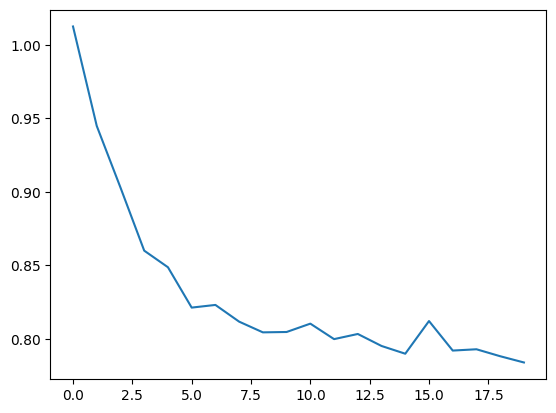

In [154]:
plt.plot(loss_list)
plt.show()

In [4]:
torch.save(model.state_dict(), log_dir / 'model_unet.pth')

In [7]:
def normalize_dataset_with_metadata(metadata, ts=None, bridge=None, drift=None, source=None, target=None):
    """
    Normalize the dataset using the metadata
    """
    mean_ts, std_ts = metadata['ts']
    mean_bridge, std_bridge = metadata['bridge']
    mean_drift, std_drift = metadata['drift']
    mean_source, std_source = metadata['source']
    mean_target, std_target = metadata['target']
    
    ret_ts = (ts - mean_ts) / std_ts if ts is not None else None
    ret_bridge = (bridge - mean_bridge) / std_bridge if bridge is not None else None
    ret_drift = (drift - mean_drift) / std_drift if drift is not None else None
    ret_source = (source - mean_source) / std_source  if source is not None else None
    ret_target = (target - mean_target) / std_target if target is not None else None
    
    return ret_ts, ret_bridge, ret_drift, ret_source, ret_target

In [5]:
# model, mean, std = load_norm_model(model, log_dir)
test_ts, test_bridge, test_drift, test_source_sample, test_target_sample = gen_mnist_data(nums=1000)
# test_ts, test_bridge, test_drift, test_source_sample, test_target_sample = normalize_dataset_with_metadata(new_ds.metadata, test_ts, test_bridge, test_drift, test_source_sample, test_target_sample)
# test_ts, test_bridge, test_drift, test_source_sample, test_target_sample = reverse_normalize_dataset(new_ds.metadata, new_ds.ts, new_ds.bridge, new_ds.drift, new_ds.source_sample, new_ds.target_sample)

100%|██████████| 1000/1000 [00:06<00:00, 151.24it/s]


In [ ]:
new_ds = pickle.loads(open('experiments/gaussian2minst/data/new_ds_0.pkl', 'rb').read())


In [9]:
model.load_state_dict(torch.load(log_dir / 'model_unet.pth'))

<All keys matched successfully>

In [9]:

# test_source_sample = new_ds.source_sample
# test_bridge = new_ds.bridge
# test_drift = new_ds.drift
# test_ts = new_ds.ts
# test_source_sample = source_sample
from utils.data_utils import normalize_dataset_with_metadata, reverse_normalize_dataset
pred_bridge = torch.zeros_like(test_bridge)
pred_drift = torch.zeros_like(test_drift)


pred_bridge[0, :] = test_source_sample
model.eval()
sigma=1
with torch.no_grad():
    for i in range(len(test_ts) - 1):
        dt = (test_ts[i+1] - test_ts[i])
        test_source_sample_reshaped = test_source_sample
        test_ts_reshaped = test_ts[i].repeat(test_source_sample.shape[0]).reshape(-1, 1, 1, 1).repeat(1, 1, 28, 28)
        pred_bridge_reshaped = pred_bridge[i]
        # print(test_source_sample_reshaped.shape)
        ret = normalize_dataset_with_metadata(new_ds.metadata, source=test_source_sample_reshaped, ts=test_ts_reshaped, bridge=pred_bridge_reshaped)
        test_ts_reshaped = ret['ts']
        pred_bridge_reshaped = ret['bridge']
        test_source_sample_reshaped =  ret['source']
        x = torch.concat([test_source_sample_reshaped, test_ts_reshaped, pred_bridge_reshaped], axis=1)
        x = F.pad(x, (2, 2, 2, 2, 0, 0, 0, 0), 'constant', 0)
        dydt = model(x.to(device)).cpu()
        dydt = dydt[:, :, 2:-2, 2:-2]
        
        pred_drift[i]=dydt
        dydt = reverse_normalize_dataset(new_ds.metadata, bridge=dydt)['bridge']

        diffusion = sigma * torch.sqrt(dt) * torch.randn_like(dydt)
        
        pred_bridge[i+1] = pred_bridge[i] + dydt * dt + diffusion[:]

In [12]:
pred_image = pred_bridge[-1, :25]

In [13]:
pred_image = (pred_image - pred_image.min()) / (pred_image.max() - pred_image.min())

In [ ]:
(1000, 3, 28, 28)

(3, 28, 28)

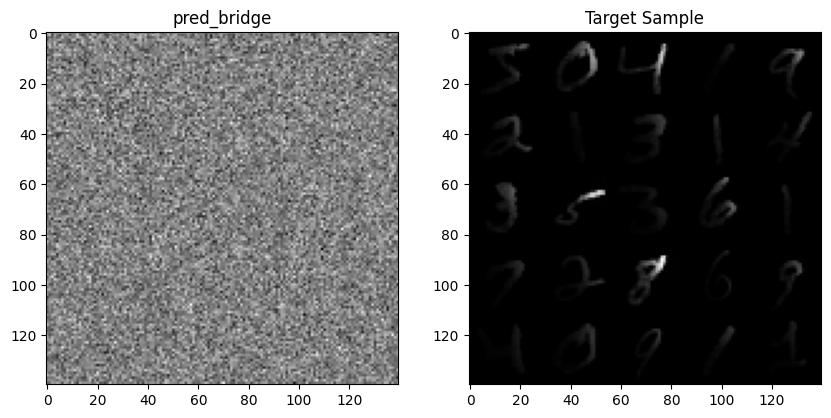

In [17]:
# def binary1(x):
#     x = torch.where(x < 0.99, torch.ones_like(x), torch.zeros_like(x))
#     return x
plot_source_and_target_mnist(test_bridge[0, :25], (-pred_image), left_title="pred_bridge")

In [10]:
def concat_mnist(data):
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data)
    # print(data.shape)
    # data = data[:100]
    data = data.view(5, 5, 28, 28)
    data = torch.concatenate([torch.cat([data[i, j] for j in range(5)], dim=1) for i in range(5)], dim=0)
    return data

def plot_source_and_target_mnist(sour, targ, left_title="Source Sample", right_title="Target Sample", save_path=None, bound=8):
    sour = concat_mnist(sour)
    targ = concat_mnist(targ)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(sour.cpu().numpy(), cmap='gray')
    axs[1].imshow(targ.cpu().numpy(), cmap='gray')
    axs[0].set_title(left_title)
    axs[1].set_title(right_title)
    fig.show()
    if save_path is not None:
        fig.savefig(save_path)
        
def save_gif_frame_mnist1(bridge, save_path=None, save_name='brownian_bridge.gif'):
    assert save_path is not None, "save_path cannot be None"
    save_path = Path(save_path)
    bridge = bridge[::10, :, :].numpy()  # 降低采样率

    temp_dir = save_path / 'temp'
    if temp_dir.exists():
        shutil.rmtree(temp_dir)
    temp_dir.mkdir(exist_ok=True)
    frame = 0
    
    # color_map = -np.sqrt(bridge[0, :, 0]**2 + bridge[0, :, 1]**2)
    for i in track(range(bridge.shape[0]), description="Processing image"):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.clear()
        ax.imshow(concat_mnist(bridge[i]).cpu().numpy(), cmap='gray')
        fig.savefig(save_path / 'temp' / f'{frame:03d}.png', dpi=100)
        frame += 1
        fig.show()
        plt.close('all')
    frames = []
    for i in range(bridge.shape[0]):
        frame_image = imageio.imread(save_path / 'temp' / f'{i:03d}.png')
        frames.append(frame_image)
    imageio.mimsave(save_path / save_name, frames, duration=0.2)
    if temp_dir.exists():
        shutil.rmtree(temp_dir)
        
save_gif_frame_mnist1(pred_bridge[:,:25], log_dir, 'test2.gif')

/home/ljb/miniconda3/envs/sde/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/tmp/ipykernel_487363/145018959.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame_image = imageio.imread(save_path / 'temp' / f'{i:03d}.png')
